# DeepBeerLevelz

DISCLAIMER: No beer was wasted in the making of this project.

## Contents:
- [Motivation](#motivation)
- [Data collection with webcam (.py file)](#collection)
- [Modelling CNN](#modelling)
    * [Loading data](#loading)
- [Training](#training)
- [Making evidential video](#testing)
- [Live volume prediction (.py f)](#find-clustering)
- [Summary and thoughts](#summary)

## Motivation <a class="anchor" id="motivation"></a>

I was enjoying drinks with a friend at my flat and were drinking a particularly exceptional lambic beer (Cantillon Brabantiae, 2018. See: https://www.cantillon.be/) and wanted to ensure to distribute it as equitatively as possible.

Unfortunately I've never made the habit of buying glasses and thus have no matching glasses and just a collection of small missmatched glasses and jars. We tried our best to be equitative by timing the time of pouring with a consistent stream size rather than by judging the volume. We took this approach because we knew that evaluating volume can be deceptive, especially with nonlinear shaped glasses such as some of mine [Pechey et al, (2015). *PLoS One*. 10(12):e0144536. https://doi.org/10.1371/journal.pone.0144536]:

<img src="notebook_images/wine_glasses.png" alt="Glasses_wine" style="width: 600px;"/>

We further reasoned that as this is a 750ml beer bottle. If we were off by a relatively small amount, say one person received 120ml and the other 100ml. The more small glasses we had, the larger the disparity of consumption we would have if the difference between servings remained consistent. Indeed for this particular bottle, it would mean that one person would consume on average 20% more than the other. In the end we consumed two 750ml bottles, if one consumed 20% more than the other. Following the simple formula

$$
x + 1.2*x = 1500ml
$$

One can find that in the end one person drinks 681ml, while the other drinks 818ml, a full 147ml more than the other, more than a full glass!

In the end we got distracted by other topics and estimated our servings, yet the question stuck with me for a couple of days. Then I wondered, could I device a computer vision model that accurately returns the volume in the glass? I thought it could be a fun regression problem, upon researching further I found that there are comparatively few computer vision deep neural network models solving regression than classification or detection problems. I am not sure if there are simply overall less such problems to solve or there is something about them that makes them more troublesome.

I have a webcam, and I can train the model with accurate measurements, so let's give it a go.

## Data Collection with webcam (.py file) <a class="anchor" id="collection"></a>

I do not want to spend time drawing boxes around my glasses, as I'm generating the data I want minimal anotation. Therefore I simply set up the same background for each of my glasses, reasoning that this is quite functional too, and will help the model to ignore variations in the background that do not help in determining the volume of the glass. I may in future download some pre-trained model that can detect glasses and use it to make the model more flexible to the background.

I collected images of two of my glasses at different volume levels and with variations in camera angle, and minimally also in foam levels in the beer. I wanted a working model so as stated above the background was always similar though not exactly the same. For image collection, as well as for other parts of the training I adapted a code developed here (https://github.com/SouravJohar/rock-paper-scissors) to detect hand gestures for playing rock-paper-scissors as it already implemented useful components.

I filled up each glass with liquid at intervals of 10ml from 0ml to 120ml which is the limit of the smaller glass.

<table><tr>
<td> <img src="image_data/1g0/14.jpg" alt="Glasses_wine" style="width: 140px;"/> 0ml </td>
<td> <img src="image_data/2g30/14.jpg" alt="Glasses_wine" style="width: 140px;"/> 30ml </td>
<td> <img src="image_data/1g60/14.jpg" alt="Glasses_wine" style="width: 140px;"/> 60ml </td>
<td> <img src="image_data/2g90/14.jpg" alt="Glasses_wine" style="width: 140px;"/> 90ml </td>
<td> <img src="image_data/1g120/14.jpg" alt="Glasses_wine" style="width: 140px;"/> 120ml </td>
</tr></table>

Below is the code used for data collection, originally its own code "collect_data.py"

In [6]:
desc = '''Script to gather data images with a particular label.

Usage: python collect_data.py <label_name> <num_samples>

The script will collect <num_samples> number of images and store them
in its own directory.

Only the portion of the image within the box displayed
will be captured and stored.

Press 'a' to start/pause the image collecting process.
Press 'q' to quit.

'''

import cv2
import os
import sys

try:
    label_name = sys.argv[1]        
    num_samples = int(sys.argv[2])
except:
    print("Arguments missing.")
    print(desc)
    exit(-1)

IMG_SAVE_PATH = 'image_data'        # Where to save the images
IMG_CLASS_PATH = os.path.join(IMG_SAVE_PATH, label_name)

try:
    os.mkdir(IMG_SAVE_PATH)         # Make the directory for all data
except FileExistsError:             # Unless it already exists
    pass
try:
    os.mkdir(IMG_CLASS_PATH)        # Make the directory for this data
except FileExistsError:             # Unless it already exists
    print("{} directory already exists.".format(IMG_CLASS_PATH))
    print("All images gathered will be saved along with existing items in this folder")

cap = cv2.VideoCapture(0)           # Start camera
cap.set(cv2.CAP_PROP_AUTOFOCUS, 0)  # turn the autofocus off, my camera is very annoying with this
cap.set(28, 600)  # I fix the focus of the camera, otherwise my specifical model of webcam makes a mess

start = False
count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        continue

    if count == num_samples:    #If sample number is collected, then finish
        break

    #Make rectangle frame for image, half of the camera
    cv2.rectangle(frame, (320, 0), (640, 500), (255, 255, 255), 2)

    if start:
        roi = frame[0:500, 320:640]   # Define ROI to match drawing,
        save_path = os.path.join(IMG_CLASS_PATH, '{}.jpg'.format(count + 1))
        cv2.imwrite(save_path, roi)     # Where to write and increase counter
        count += 1

    font = cv2.FONT_HERSHEY_SIMPLEX     # Define font of numbers
    cv2.putText(frame, "Collecting {}".format(count),   # Writes text of collecting #
            (5, 50), font, 0.7, (0, 255, 255), 2, cv2.LINE_AA)
    cv2.imshow("Collecting images", frame)

    k = cv2.waitKey(10)
    if k == ord('a'):       # Start if 'a'
        start = not start

    if k == ord('q'):       # Quit if 'q'
        break

print("\n{} image(s) saved to {}".format(count, IMG_CLASS_PATH))
cap.release()   # stop recording
cv2.destroyAllWindows() # close recording window

## Modelling CNN <a class="anchor" id="modelling"></a>

I realised that 10ml is so fine-grained that I could also just make a classification algorythm which would give a reasonable estimate but I still wanted to try a regression. As there are so many great resources out there, I went for the well established and lightweight model "SqueezeNet" [Iandola et al, (2016). arXiv:1602.07360. https://doi.org/10.48550/arXiv.1602.07360 ]. I then needed simply to remove the head and train a few final layers:
- I performed a Dropout to take care against overfitting
- A simple 2D Convolution to compress the data somewhat and hopefully distill the important parameters
- Global Average Pooling, to linearise the network and also compress it further
- A dense layer just in case a bit of processing is still required, probably not but shouldn't hurt
- A dense layer with a softplus function for our regression. I prefered softplus over linear as I don't want my model predicting negative values. I chose softplus over "relu" as I found that relu does odd things to the loss function when the training data is actually zero.

I did try more complex networks just for fun but there was minimal to no improvement, so unless problem becomes more complicated and the loss no longer seems adequate, there is no reason to make the model more complicated.

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from squeezenet import SqueezeNet
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers import Activation, Dropout, Convolution2D, GlobalAveragePooling2D, Dense, MaxPool2D, Conv2DTranspose
from keras.models import Sequential
import os
import re
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
def get_model():
    model = Sequential([
        SqueezeNet(input_shape=(227, 227, 3), include_top=False),
        Dropout(0.5),
        Convolution2D(128, (1, 1), padding='valid'),
        GlobalAveragePooling2D(),
        Dense(64,'relu',kernel_initializer='he_uniform'),
        Dense(1,'softplus')
    ])
    return model

In [3]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 squeezenet (Functional)     (None, 13, 13, 512)       722496    
                                                                 
 dropout (Dropout)           (None, 13, 13, 512)       0         
                                                                 
 conv2d (Conv2D)             (None, 13, 13, 128)       65664     
                                                                 
 global_average_pooling2d (G  (None, 128)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

### Loading data <a class="anchor" id="loading"></a>
I take imported data and use regular expressions on the folder title to define the training value. Originally I had trained each glass with a different model, yet I thought it would be nice to just train everything with the same model and just have the model figure it out. Conceptually I find this interesting it's conceivable that if one successfully trains with a sufficient number of glasses the model will be able to interpolate new glasses types it hasn't seen.

In [4]:
dir_data = 'image_data'
glass_Train = ""
# load images from the directory
dataset = []
for directory in os.listdir(dir_data):
    if glass_Train in directory:
        path = os.path.join(dir_data, directory)
        print(path)
        if not os.path.isdir(path):
            continue
        for item in os.listdir(path):
            # to make sure no hidden files get in our way
            if item.startswith("."):
                continue
            img = cv2.imread(os.path.join(path, item))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (227, 227))
            dataset.append([img, directory])

image_data/2g110
image_data/1g50
image_data/2g50
image_data/1g0
image_data/2g70
image_data/2g10
image_data/1g20
image_data/2g90
image_data/1g10
image_data/2g120
image_data/2g100
image_data/1g120
image_data/1g70
image_data/1g110
image_data/1g40
image_data/1g90
image_data/1g60
image_data/2g30
image_data/2g20
image_data/2g60
image_data/1g80
image_data/1g100
image_data/2g40
image_data/2g0
image_data/1g30
image_data/2g80


In [5]:
def mapper(label):
    return(int(re.sub("[1-2]g","",label)))

data, labels = zip(*dataset)
labels = list(map(mapper,labels))

## Training <a class="anchor" id="training"></a>
The model trains relatively fast, in about 10 minutes.My laptop, though 5 years old, has an integrated NVIDIA Quadro M1200, 4 GB RAM, 128 Bit width, 5000 MHz Clock Speed GPU which integrates neatly with tensorflow's CUDA functionality and works well enough.

In [15]:
# define the model
model = get_model()
print(model.summary())
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='log_cosh', # I tried MAE and it worked pretty well, I don't see too much difference with log_cosh, however
                     # I realised interestingly that log_cosh leads to a faster reduction of loss when the values
                     # are smaller, I think that makes sense from looking at the function shape near zero compared
                     # to absolute
    metrics=['mean_absolute_error']
)

# start training
history = model.fit(np.array(data), np.array(labels), epochs=10)

# save the model for later use
model.save("deepBeerLevelz.h5")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 squeezenet (Functional)     (None, 13, 13, 512)       722496    
                                                                 
 dropout_2 (Dropout)         (None, 13, 13, 512)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       65664     
                                                                 
 global_average_pooling2d_2   (None, 128)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                      

I check the mean absolute error and explained variance on our separate validation dataset. The mean absolute error is pretty good. Absolute error is intuitive for this type of scenarios as it can relate back to physical terms, we can directly interpret that the measurement is on average off by 1.038ml (may vary), not bad at all! A relative error would be a bit more difficult to interpret as we have some values that are zero. The almost one explained variance is also a good sign that we correctly capture the dynamics of our training data.

In [7]:
from keras.models import load_model
model = load_model("deepBeerLevelz.h5")
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

data_pred = model.predict(np.array(data))
print("MAE: "+str(np.round(mean_absolute_error(labels,data_pred),3))+" (ml)")
print("EV: "+str(np.round(explained_variance_score(labels,data_pred),3)))

2022-03-23 22:15:23.016428: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1205778600 exceeds 10% of free system memory.
2022-03-23 22:15:23.816398: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1205778600 exceeds 10% of free system memory.


MAE: 1.038 (ml)
EV: 0.999


## Testing on separate datasets, and testing the regression <a class="anchor" id="testing"></a>
The steps so far suggest that the model can return values pretty well, but so far all the data is still in steps of 10. It also doesn't seem to struggle with the fact that there are two glass types. I then create new datasets with values the model has not trained for and analyse whether it is able to correctly interpolate the values for both glass types. Also since these values aren't very small it's possible to use percentage error too.

In [7]:
# model = load_model("deepBeerLevels.h5")
dir_test = "test_datasets/"
glass_Test = ""
# load images from the directory
dataset_test = []
for directory in os.listdir(dir_test):
    if glass_Test in directory:
        path = os.path.join(dir_test, directory)
        print(path)
        if not os.path.isdir(path):
            continue
        for item in os.listdir(path):
            # to make sure no hidden files get in our way
            if item.startswith("."):
                continue
            img = cv2.imread(os.path.join(path, item))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (227, 227))
            dataset_test.append([img, directory])

test_datasets/1g105
test_datasets/2g105
test_datasets/1g95
test_datasets/1g25
test_datasets/2g95
test_datasets/2g25


In [8]:
data_test, labels_test = zip(*dataset_test)
labels_test = list(map(mapper,labels_test))

from sklearn.metrics import mean_absolute_percentage_error

data_pred = model.predict(np.array(data_test))
print("MAE: "+str(np.round(mean_absolute_error(labels_test,data_pred),3))+" (ml)")
print("MAPE: "+str(np.round(mean_absolute_percentage_error(labels_test,data_pred),3)))
print("EV: "+str(np.round(explained_variance_score(labels_test,data_pred),3)))

MAE: 1.452 (ml)
MAPE: 0.029
EV: 0.997


While the model has slightly more error (1.417ml), it will be able to accurately predict the value within a tolerable error!

All that's left now is to make a fun video of beer being poored and the model predicting the values:

## Making evidential video <a class="anchor" id="video"></a>

In [9]:
dir_sequence = "sequence_datasets/2gsequence/"
dataset_sequence = []
for item in os.listdir(dir_sequence):
    # to make sure no hidden files get in our way
    if item.startswith("."):
        continue
    img = cv2.imread(os.path.join(dir_sequence, item))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (227, 227))
    dataset_sequence.append(img)
    
order_sequence = np.argsort([int(re.sub(".jpg","",im)) for im in os.listdir(dir_sequence)])
dataset_sequence = np.array(dataset_sequence)[order_sequence]
predict_sequence = (model.predict(dataset_sequence))[:,0]

One can see that the predicted level increases over time either from pooring or from foam becoming liquid. In hindsight I could have made my training datasets include foam and thus account for that, definitely for a future model. So to be accurate the model calculates the amount of liquid beer.

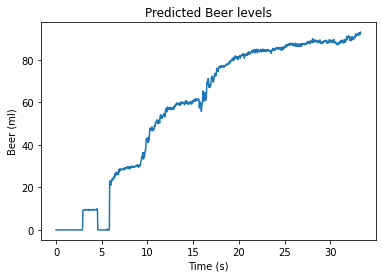

In [10]:
plt.plot(np.arange(0,999/30+0.001,1/30),predict_sequence);
plt.title("Predicted Beer levels");
plt.xlabel("Time (s)");
plt.ylabel("Beer (ml)");

I then simply label the images and make a video using ffmpeg command line which I'm more familiar with for such tasks.

In [11]:
from PIL import Image, ImageFont, ImageDraw

dir_sequence_out = "sequence_datasets/2gsequence_predict/"
try:
    os.mkdir(dir_sequence_out)         # Make the directory for all data
except FileExistsError:             # Unless it already exists
    pass
title_font = ImageFont.truetype('font/arial_narrow_7.ttf', 30)

for i, item in enumerate(os.listdir(dir_sequence)):
    # to make sure no hidden files get in our way
    if item.startswith("."):
        continue
    my_image = Image.open(os.path.join(dir_sequence, item))
    title_text = "Predicted: "+str(np.round(predict_sequence[int(re.sub(".jpg","",item))-1],1))+"ml"
    image_editable = ImageDraw.Draw(my_image)
    image_editable.text((15,440), title_text, (235, 235, 235), font=title_font)
    my_image.save(dir_sequence_out + re.sub(".jpg","_marked.jpg",item.zfill(8)))

In [12]:
os.system("ffmpeg -framerate 30 -i "+dir_sequence_out+"%04d_marked.jpg -c:v libx264 ../2gsequence_video.mp4")

I've embedded the video below of a glass filling up with beer and its predicted value. When running the code "predict_volume.py" below, one can get a similar output in real time.

<video controls src="sequence_datasets/2gsequence_video.mp4" />

Link in case the video does not play, which seems to happen with markdown on github: https://github.com/edgar-hd/deepBeerLevelz/tree/main/sequence_datasets/2gsequence_video.mp4

## Live volume prediction <a class="anchor" id="live"></a>
Below is the code "predict_volume.py" which when run displays a screen that uses the webcam to predict the value of the glass in front of the camera in real time. Fun to use with friends to get an exact measurement, and also take guesses as to who can serve for example 50ml the most precisely and other similar simple games.

In [ ]:
desc = '''Script to produce glass volume in real time.

Press 'q' to quit.

'''

from keras.models import load_model
import cv2
import numpy as np
from random import choice

model = load_model("deepBeerLevelz.h5")

cap = cv2.VideoCapture(0)           # Start camera
cap.set(cv2.CAP_PROP_AUTOFOCUS, 0)  # turn the autofocus off
cap.set(28, 560) 

while True:
    ret, frame = cap.read()
    if not ret:
        continue

    # rectangle for user to play
    cv2.rectangle(frame, (320, 000), (640, 500), (255, 255, 255), 2)

    # extract the region of image within the user rectangle
    roi = frame[000:500, 320:640]   # Define ROI to match drawing,
    img = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (227, 227))


    # predict the move made
    pred = model.predict(np.array([img]))
    move_code = pred[0,0]

    # display the information
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, "Volume: " + str(move_code) + "ml",
                (50, 50), font, 1.2, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow("Test", frame)

    k = cv2.waitKey(10)
    if k == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

## Summary and thoughts <a class="anchor" id="summary"></a>
I have made a prototype algorithm able to accurately calculate the amount of blond beer in my house glasses. These glasses are substantially different to each other and have irregular shapes and patterns that the algorithm is able to overcome, and it still accurately returns the volume. It also seems to focus sufficiently on the glass such that a stream of liquid doesn't affect the measurements too much, and the slight variations in angles mean I don't need to worry too much about where I place my glass, as long as it's roughly a similar position.

Some thoughts:
- I had not accounted for foam in the beer, and a clear future develompent is to train the algorithm for different amount of foam with the same total beer volume. At present it calculates how much liquid beer is in the glass. As we know from the study of polydispersed fluids, depending on the beer type and speed of pouring the density of the foam may be different, the density may also not be uniform along the *y* axis thus leading to differences in the prediction, I don't know how substantial the differences in density can truly be but it's an interesting thought nonetheless.

- I tried a pre-trained image detection algorithm and it consistently captured the glass, which could help me to develop a more tailored approache where the glass can be in more diverse positions and backgrounds (https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1 and https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1). The image detection algorithm however is comparatively very slow, and also sometimes trims the glasses in half, so further training would need to be done on that network for my specific objects, this is meant to be a fun project so I don't want to spend loads of time drawing boxes around glasses. I suspect the fact they are transparent is a major issue for accurate detection.

- If I were to fit this to more beer types, say stout, brune, etc. The algorithm may be able to interpolate between different beer types, this may be a future development. At present I have only blond belgian beers at home, and have done for the last week.

- It could be interesting also if I fit more glass types, would the neural network eventually be able to perform decently on glasses it hasn't seen before? I suspect not, but maybe similar glasses? Or a broken glass? This feels a bit like speculating about the "black box" but still interesting to think about.